<a href="https://colab.research.google.com/github/m-lokeshnaik/classification-of-covid-varients-based-on-protein-sequences/blob/main/model_comparision_of_protein_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
# @title essential libraries
# !pip install catboost
# !pip install xgboost
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install sklearn
# !pip install seaborn
# !pip install scipy
# !pip install openpyxl
# !pip install BaggingClassifier
# !pip install DecisionTreeClassifier
# !pip install GradientBoostingClassifier
# !pip install RandomForestClassifier
# !pip install SelectKBest
# !pip install mutual_info_classif
# !pip install f_classif
# !pip install chi2

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.cm as cm


#data loading


In [101]:
# Load the Excel files
df = pd.read_excel(r"/content/protein sequence in numreical.xlsx")

In [102]:
df.isnull().sum()

,0
Alanine(A),0
Arginine (R),0
Asparagine(N),0
Aspartic acid(D),0
Cysteine (C),0
Glutamine(Q),0
Glutamic acid(E),0
Glycine(G),0
Histidine(H),0
Isoleucine(I),0


In [103]:
df.head()

,Alanine(A),Arginine (R),Asparagine(N),Aspartic acid(D),Cysteine (C),Glutamine(Q),Glutamic acid(E),Glycine(G),Histidine(H),Isoleucine(I),...,Leucine(K),Methionine(M),Phenylalanine(F),Proline(P),Serine(S),Threonine(T),Tryptophan(W),Tyrosine(Y),Valine(V),class labels
0,24,27,25,24,2,28,19,34,10,14,...,28,4,23,32,52,27,5,16,19,HCoV-HKU1
1,10,8,11,7,3,5,3,11,2,21,...,12,8,21,7,16,18,6,10,19,HCoV-HKU1
2,9,10,32,21,15,6,5,19,9,28,...,18,2,39,17,42,10,4,33,24,HCoV-HKU1
3,24,27,25,24,2,28,19,34,10,14,...,28,4,23,32,52,27,5,16,19,HCoV-HKU1
4,10,8,11,7,3,5,3,11,2,21,...,12,8,21,7,16,18,6,10,19,HCoV-HKU1


In [104]:

# Assuming 'df' is your DataFrame
scaler = MinMaxScaler()

# Select numerical columns (excluding 'class labels')
numerical_cols = df.columns[:-1]

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print(df)

     Alanine(A)  Arginine (R)  Asparagine(N)  Aspartic acid(D)  Cysteine (C)  \
0        0.2875      0.254902       0.261364          0.366667         0.050   
1        0.1125      0.068627       0.102273          0.083333         0.075   
2        0.1000      0.088235       0.340909          0.316667         0.375   
3        0.2875      0.254902       0.261364          0.366667         0.050   
4        0.1125      0.068627       0.102273          0.083333         0.075   
..          ...           ...            ...               ...           ...   
795      0.4500      0.215686       0.170455          0.400000         0.075   
796      0.3125      0.303922       0.511364          0.400000         0.375   
797      0.6000      0.343137       0.056818          0.350000         0.275   
798      0.1375      0.107843       0.068182          0.383333         0.025   
799      0.2250      0.235294       0.215909          0.316667         0.175   

     Glutamine(Q)  Glutamic acid(E)  Gl

In [105]:
# Separate features and labels
X = df.drop(columns=['class labels'])
y = df['class labels']


In [106]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [107]:

# Feature selection function
def select_features(X, y, method, k=10):
    if method == 'IG':
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
    elif method == 'ANOVA':
        selector = SelectKBest(score_func=f_classif, k=k)
    elif method == 'Chi2':
        X = X.apply(np.int64)  # Chi2 requires non-negative values
        selector = SelectKBest(score_func=chi2, k=k)
    elif method == 'MI':
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
    else:
        raise ValueError("Unknown method: {}".format(method))

    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    feature_names = X.columns[selected_features]
    return X_new, selected_features, feature_names, selector

In [108]:

# Select top 10 features using each method
X_ig, selected_features_ig, feature_names_ig, _ = select_features(X, y, method='IG', k=10)
X_anova, selected_features_anova, feature_names_anova, _ = select_features(X, y, method='ANOVA', k=10)
X_chi2, selected_features_chi2, feature_names_chi2, _ = select_features(X, y, method='Chi2', k=10)
X_mi, selected_features_mi, feature_names_mi, _ = select_features(X, y, method='MI', k=10)


In [109]:
# Define classifiers
classifiers = {
    'BE': BaggingClassifier(),
    'DT': DecisionTreeClassifier(),
    'GB': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'RF': RandomForestClassifier(),
    'SVM': SVC(),
    'catboost': CatBoostClassifier(verbose=0),
    'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}


In [110]:
# Function to evaluate classifiers
def evaluate_classifiers(X, y, classifiers):
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)

        # Handle multiclass confusion matrix
        specificity = []
        for i in range(cm.shape[0]):
            tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
            fp = np.sum(cm[:, i]) - cm[i, i]
            specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)  # Handle potential division by zero

        results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Sensitivity': recall,
            'Specificity': np.mean(specificity)  # Report average specificity
        }

    return results


In [111]:
# Evaluate classifiers using features selected by Information Gain
results_ig = evaluate_classifiers(X_ig, y, classifiers)
# Evaluate classifiers using features selected by ANOVA
results_anova = evaluate_classifiers(X_anova, y, classifiers)
# Evaluate classifiers using features selected by Chi2
results_chi2 = evaluate_classifiers(X_chi2, y, classifiers)
# Evaluate classifiers using features selected by Mutual Information
results_mi = evaluate_classifiers(X_mi, y, classifiers)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:03:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:03:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.wa

In [112]:
# Combine results into a single DataFrame
results = {
    'IG': results_ig,
    'ANOVA': results_anova,
    'Chi2': results_chi2,
    'MI': results_mi
}

results_df = pd.DataFrame.from_dict({(method, clf): metrics
                                     for method, method_results in results.items()
                                     for clf, metrics in method_results.items()}, orient='index')


In [113]:
results_df = pd.DataFrame.from_dict({(method, clf): {k: v * 100 if k in ['Accuracy', 'Precision', 'Sensitivity', 'Specificity'] else v
                                                      for k, v in metrics.items()}
                                     for method, method_results in results.items()
                                     for clf, metrics in method_results.items()}, orient='index')


In [131]:
results_df

Accuracy  Precision  Sensitivity  Specificity
IG    BE          96.250  96.628736       96.250    99.470495
      DT          96.875  97.226562       96.875    99.561074
      GB          97.500  97.611084       97.500    99.646779
      KNN         95.000  95.868056       95.000    99.299095
      RF          97.500  97.693841       97.500    99.648111
      SVM         45.000  43.143644       45.000    92.470875
      catboost    98.125  98.476562       98.125    99.744898
      xgboost     97.500  97.611084       97.500    99.646779
ANOVA BE          96.250  96.323260       96.250    99.449871
      DT          94.375  94.650190       94.375    99.184301
      GB          98.750  98.820685       98.750    99.823725
      KNN         96.250  96.240295       96.250    99.457420
      RF          98.750  98.850000       98.750    99.817518
      SVM         38.750  33.212500       38.750    91.639156
      catboost    98.750  98.850000       98.750    99.817518
      xgboost     98.125  98.142469       98.125    99.731813
Chi2  BE          39.375  28.804474       39.375    91.743197
      DT          39.375  28.804474       39.375    91.743197
      GB          39.375  28.804474       39.375    91.743197
      KNN         45.625  40.239583       45.625    92.382801
      RF          39.375  28.804474       39.375    91.743197
      SVM         39.375  28.804474       39.375    91.743197
      catboost    39.375  28.804474       39.375    91.743197
      xgboost     39.375  28.804474       39.375    91.743197
MI    BE          96.875  97.013258       96.875    99.556200
      DT          95.625  96.493056       95.625    99.392338
      GB          98.125  98.291667       98.125    99.738691
      KNN         95.000  95.868056       95.000    99.299095
      RF          98.125  98.291667       98.125    99.738691
      SVM         45.000  43.143644       45.000    92.470875
      catboost    98.125  98.476562       98.125    99.744898
      xgboost     97.500  97.611084       97.500    99.646779

In [114]:
# Display results
for method, method_results in results.items():
    print(f'{method}:')
    for clf_name, metrics in method_results.items():
        print(f'  {clf_name}: {metrics["Accuracy"]:.2f}') # Access the 'Accuracy' value within the nested dictionary


IG:
  BE: 0.96
  DT: 0.97
  GB: 0.97
  KNN: 0.95
  RF: 0.97
  SVM: 0.45
  catboost: 0.98
  xgboost: 0.97
ANOVA:
  BE: 0.96
  DT: 0.94
  GB: 0.99
  KNN: 0.96
  RF: 0.99
  SVM: 0.39
  catboost: 0.99
  xgboost: 0.98
Chi2:
  BE: 0.39
  DT: 0.39
  GB: 0.39
  KNN: 0.46
  RF: 0.39
  SVM: 0.39
  catboost: 0.39
  xgboost: 0.39
MI:
  BE: 0.97
  DT: 0.96
  GB: 0.98
  KNN: 0.95
  RF: 0.98
  SVM: 0.45
  catboost: 0.98
  xgboost: 0.97


<ipython-input-116-efab5b3d44e8>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_classifiers)


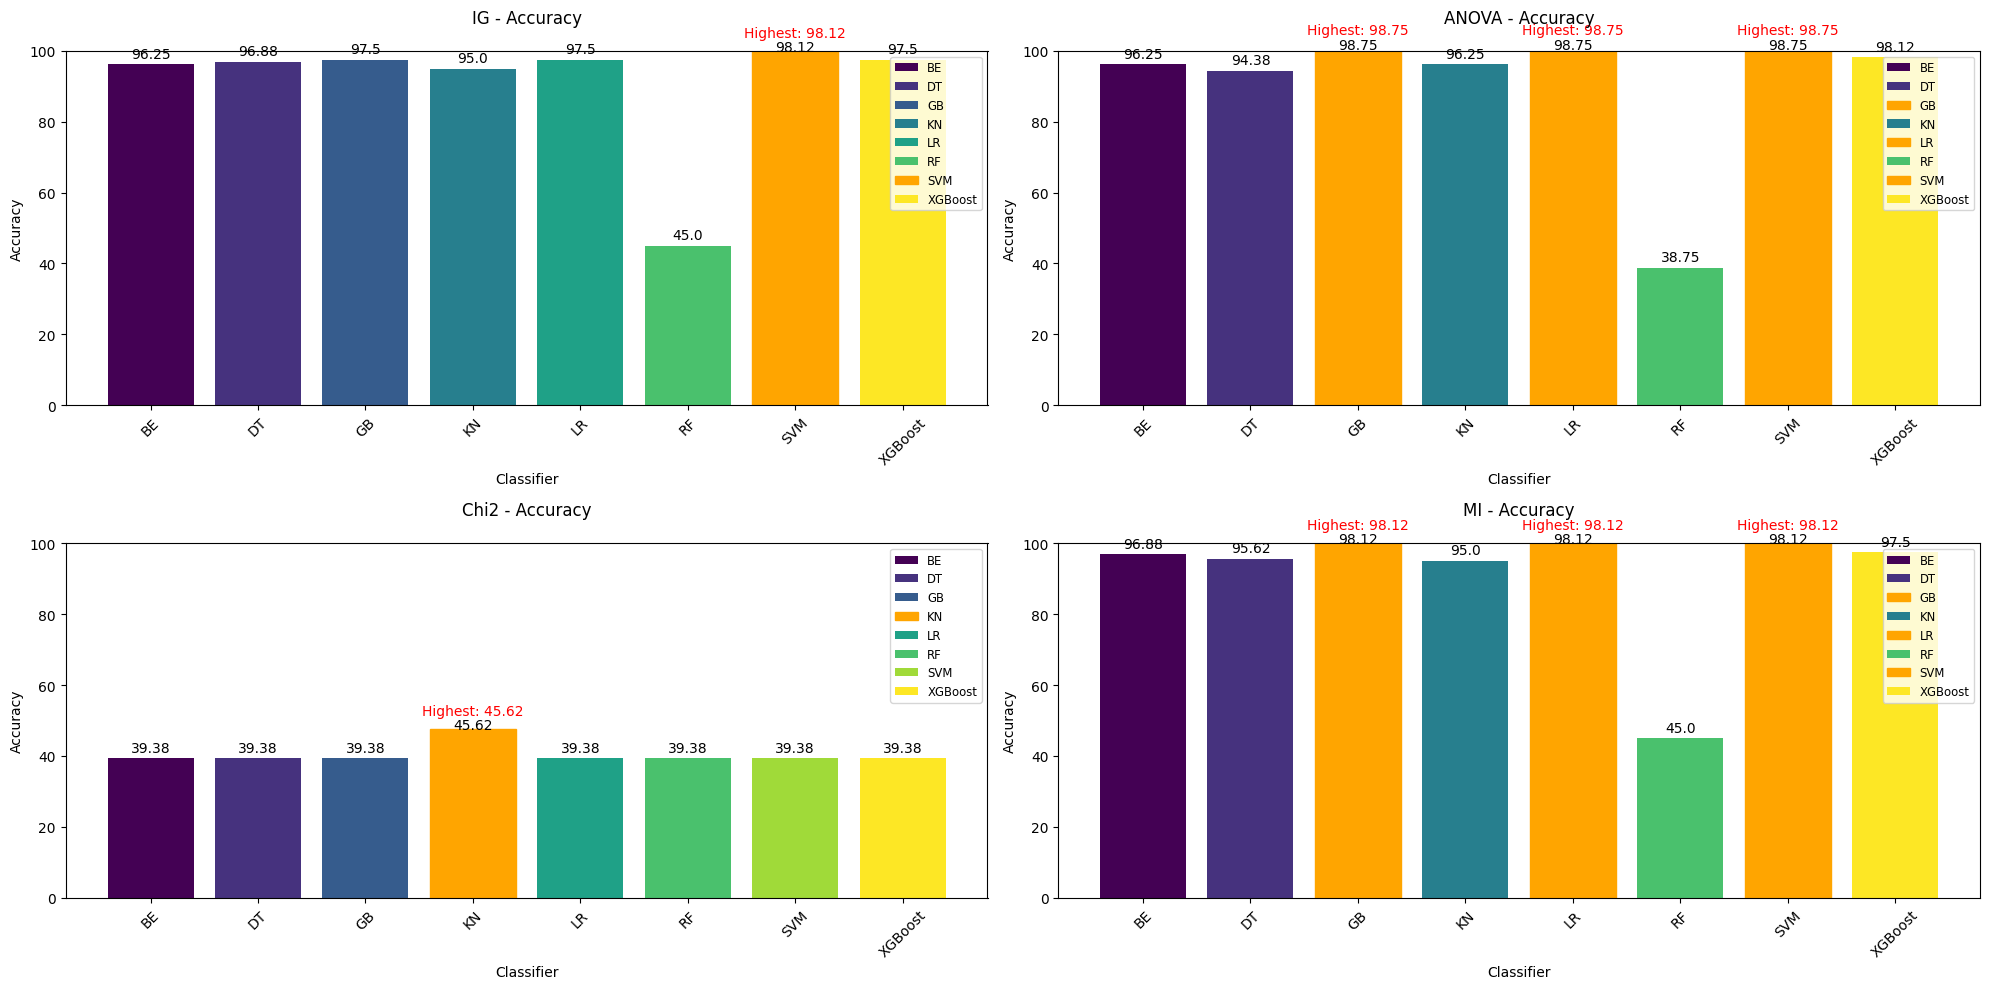

In [116]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create bar graphs for each feature selection method
def plot_performance(results, metric='Accuracy', classifier_names=None):
    methods = results.index.get_level_values(0).unique()
    if classifier_names is None:
        classifier_names = [f'Classifier {i+1}' for i in range(len(results.index.get_level_values(1).unique()))]

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    axes = axes.flatten()

    # Generate distinct colors for the bars
    num_classifiers = len(classifier_names)
    colors = cm.get_cmap('viridis', num_classifiers)

    for idx, method in enumerate(methods):
        ax = axes[idx]
        method_results = results.loc[method]
        metric_values = method_results[metric].tolist()

        # Create the bar plot with different colors and metric values displayed
        bars = ax.bar(classifier_names, metric_values, color=[colors(i) for i in range(num_classifiers)])
        ax.set_title(f'{method} - {metric}', pad=20)
        ax.set_ylim(0, 100)
        ax.set_ylabel(metric)
        ax.set_xlabel('Classifier')
        ax.tick_params(axis='x', rotation=45)

        # Add metric values on top of the bars
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

        # Highlight and label the highest values (multiple if there are ties)
        highest_value = max(metric_values)
        for i, val in enumerate(metric_values):
            if val == highest_value:
                bars[i].set_color('orange')
                bars[i].set_height(highest_value + 2)  # Increase height of highest value bar
                ax.text(bars[i].get_x() + bars[i].get_width()/2,
                        highest_value + 5,  # Adjust vertical position of label
                        f"Highest: {round(highest_value, 2)}",
                        ha='center', va='bottom', fontsize=10, color='red')

        # Add a legend to label the colors
        ax.legend(bars, classifier_names, loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()

# Example usage
classifier_names = ["BE", "DT", "GB", "KN", "LR", "RF", "SVM", "XGBoost"]
plot_performance(results_df, metric='Accuracy', classifier_names=classifier_names)


<ipython-input-116-efab5b3d44e8>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_classifiers)


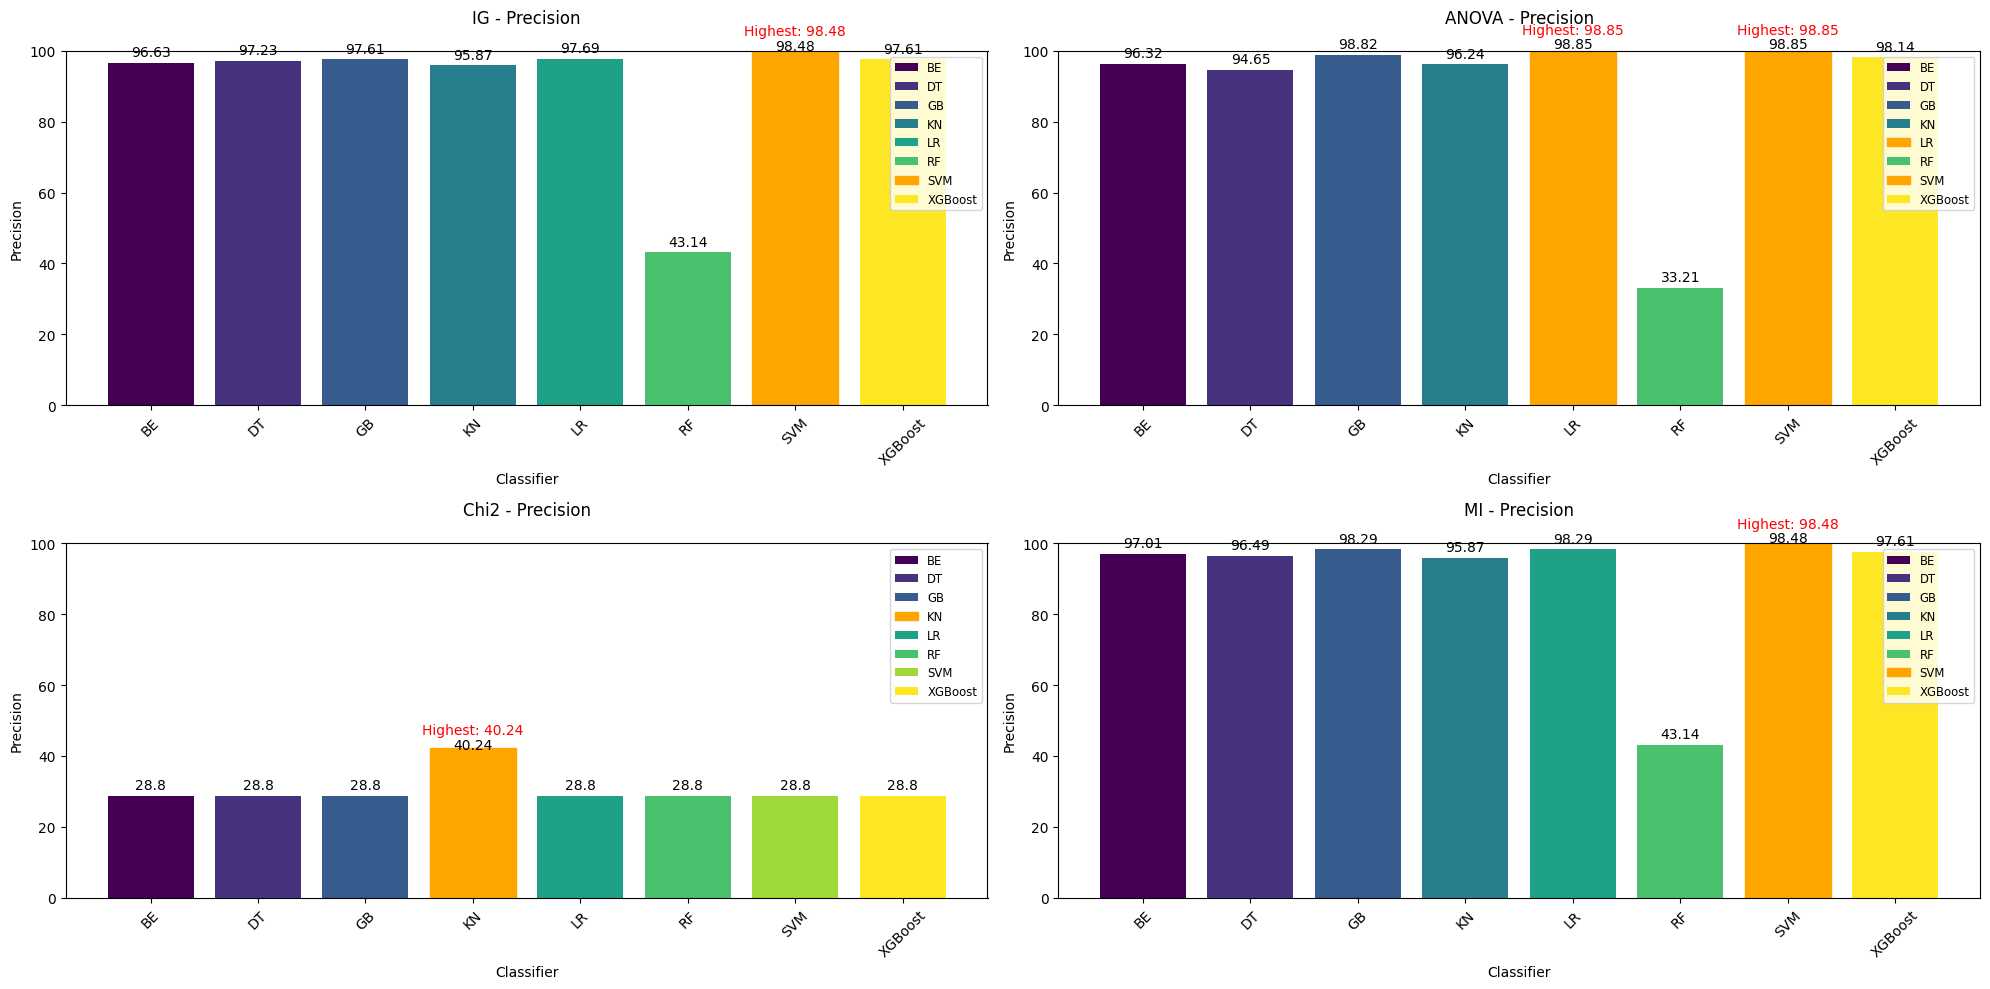

In [117]:
plot_performance(results_df, metric='Precision', classifier_names=classifier_names)

<ipython-input-116-efab5b3d44e8>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_classifiers)


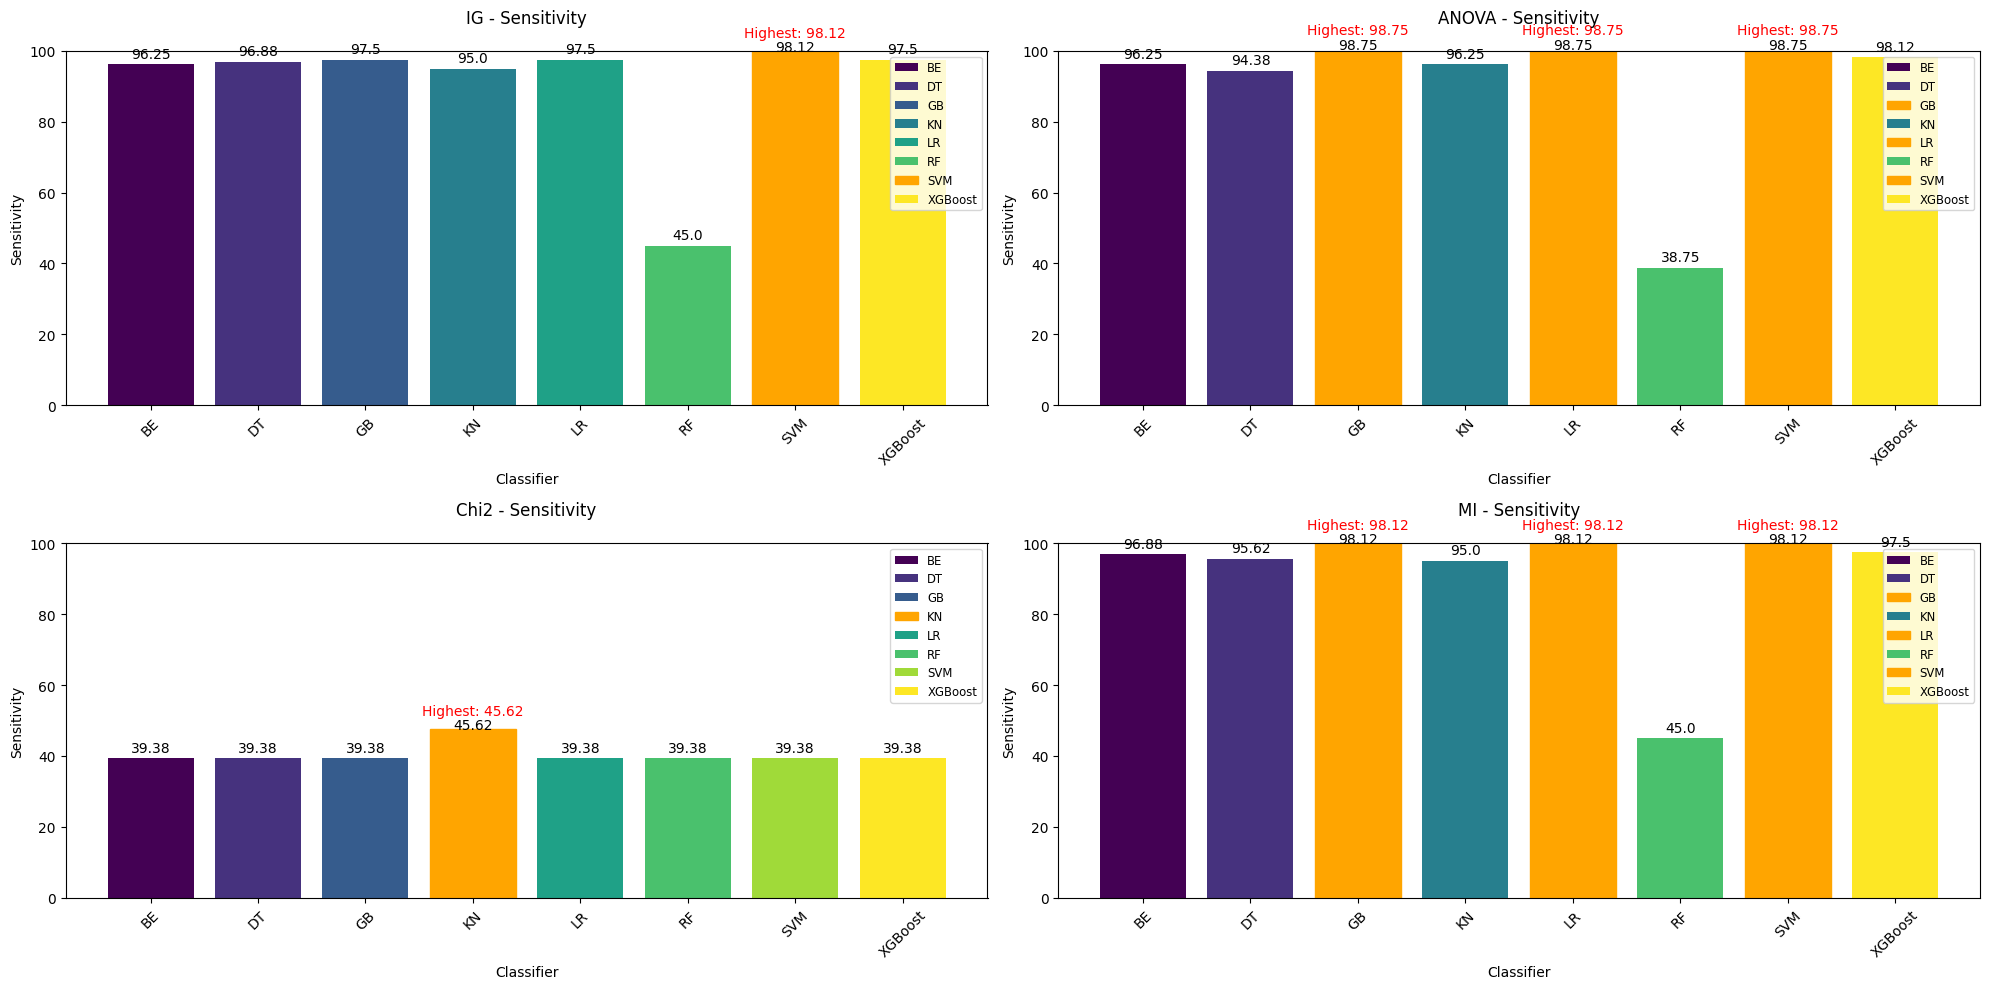

In [118]:
plot_performance(results_df, metric='Sensitivity', classifier_names=classifier_names)

<ipython-input-116-efab5b3d44e8>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_classifiers)


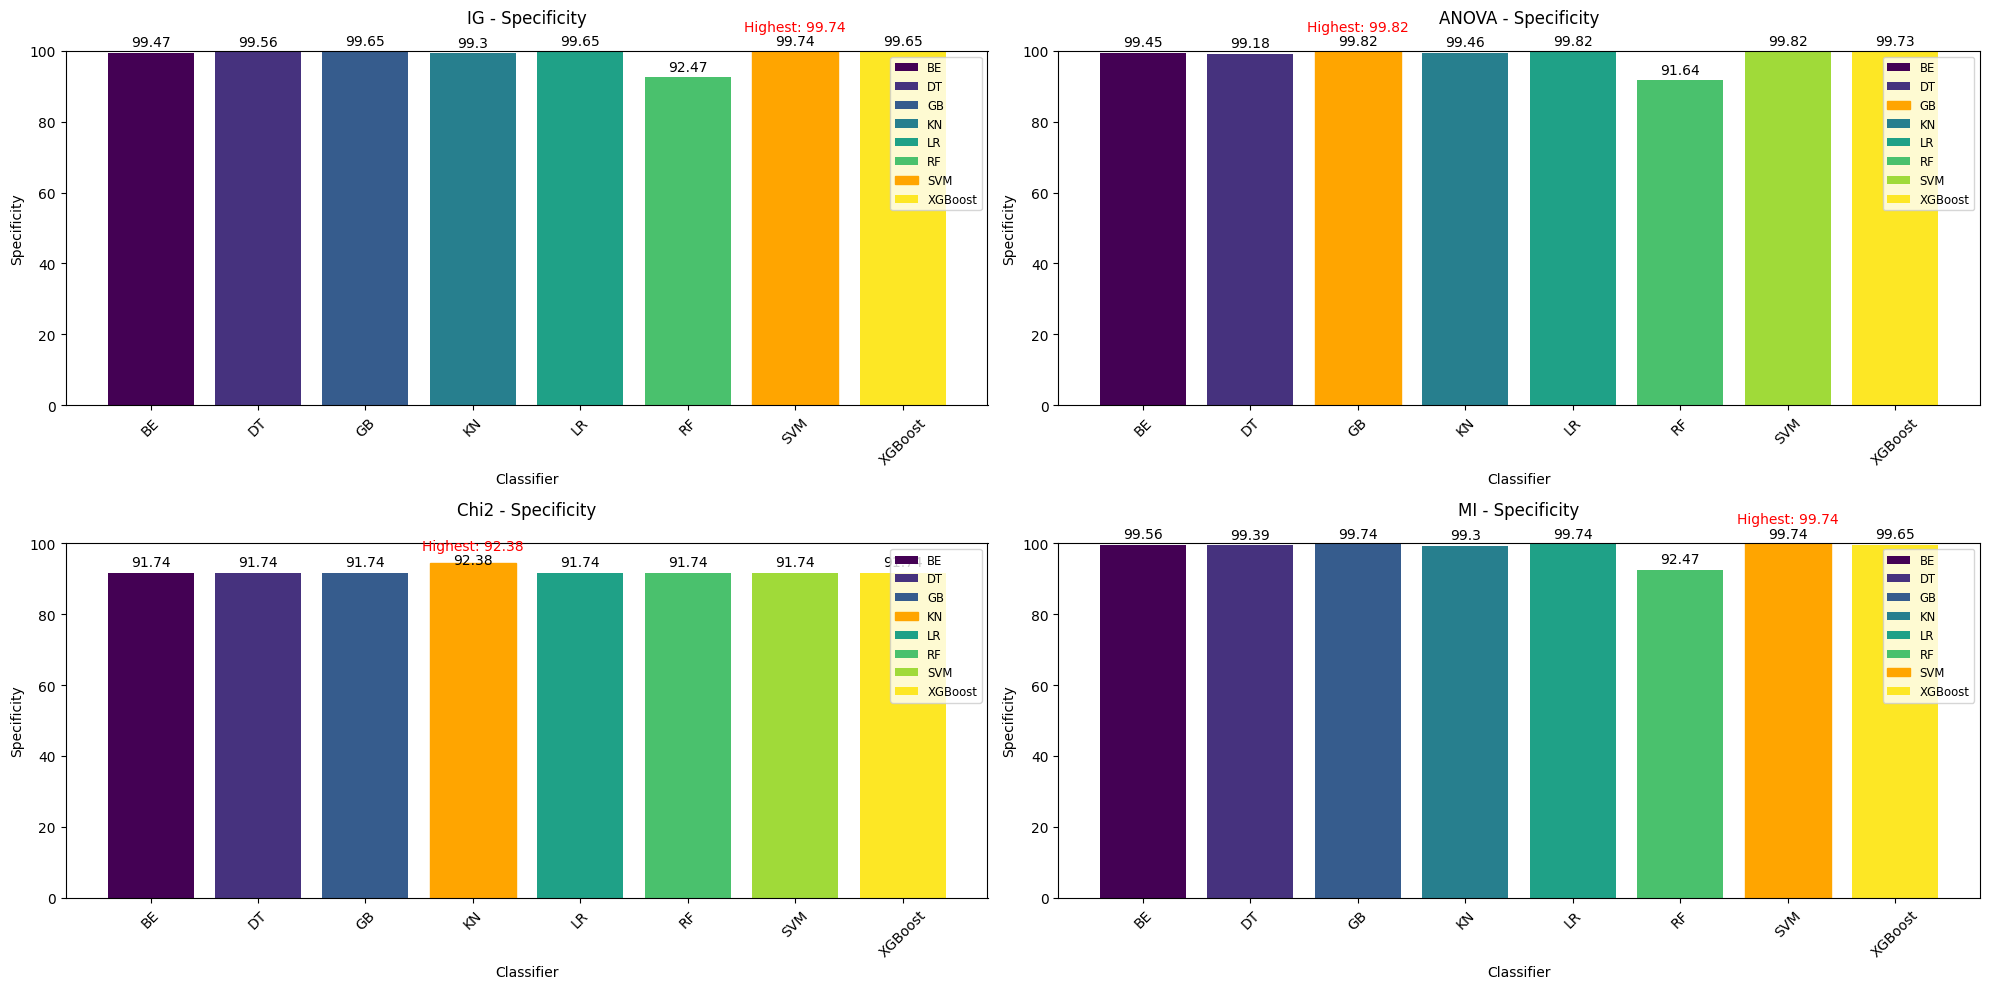

In [119]:
plot_performance(results_df, metric='Specificity', classifier_names=classifier_names)

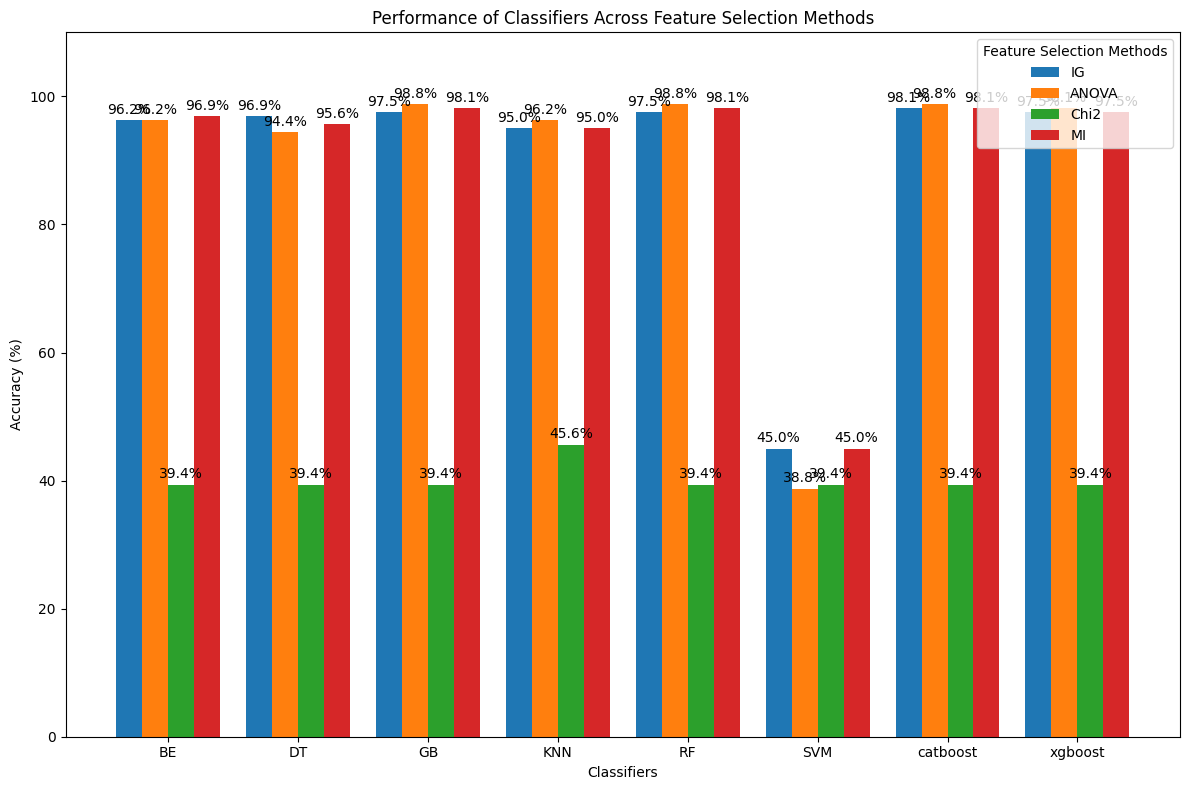

In [120]:
# @title Performance of Classifiers Across Feature Selection Methods
import matplotlib.pyplot as plt
import numpy as np

# Define the data
methods = ['IG', 'ANOVA', 'Chi2', 'MI']
classifiers = ['BE', 'DT', 'GB', 'KNN', 'RF', 'SVM', 'catboost', 'xgboost']

# Convert results to a list of accuracies for each method
def extract_accuracies(results_dict, classifiers): # Changed results_list to results_dict
    return [results_dict[clf]['Accuracy'] * 100 for clf in classifiers] # Accessing the dictionary using classifier names

# Extract the accuracy results for each feature selection method and multiply by 100
accuracy_results = {
    'IG': extract_accuracies(results_ig, classifiers), # Passing the dictionary directly
    'ANOVA': extract_accuracies(results_anova, classifiers),
    'Chi2': extract_accuracies(results_chi2, classifiers),
    'MI': extract_accuracies(results_mi, classifiers),
}
# Set up the bar width and x locations
bar_width = 0.2
x = np.arange(len(classifiers))

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for each feature selection method
for i, method in enumerate(methods):
    ax.bar(x + i * bar_width, accuracy_results[method], width=bar_width, label=method)

# Add labels, title, and legend
ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Performance of Classifiers Across Feature Selection Methods')
ax.set_xticks(x + (len(methods) - 1) * bar_width / 2)
ax.set_xticklabels(classifiers)
ax.set_ylim(0, 110)  # Adjust y-axis to accommodate percentage values
ax.legend(title='Feature Selection Methods')

# Add data labels
for i, method in enumerate(methods):
    for j, value in enumerate(accuracy_results[method]):
        ax.text(x[j] + i * bar_width, value + 1, f'{value:.1f}%', ha='center')

# Show the plot
plt.tight_layout()
plt.show()


In [90]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=results_df)

https://docs.google.com/spreadsheets/d/1m7N0OnWBq410krvpmJRaeLWVJDdU_7hkTxJlh511lLw#gid=0
